In [20]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model import resnet_unet_model, unet
import keras.backend as K
from helpers import f1
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [21]:
model = unet(256, 256, 3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 16)         448       ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_18[0][0]']          
                                                                                            

In [22]:
# Images generator (RGB)
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    'data_v2_processed/train/images',
    target_size=(256, 256),
    batch_size=6,
    class_mode=None,
    color_mode='rgb',
    seed=42)

# Masks generator (grayscale, single channel)
train_mask_datagen = ImageDataGenerator(rescale=1./255)

train_mask_generator = train_mask_datagen.flow_from_directory(
    'data_v2_processed/train/masks',
    target_size=(256, 256),
    batch_size=6,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

Found 2056 images belonging to 2 classes.
Found 2056 images belonging to 1 classes.


In [23]:
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    'data_v2_processed/val/images',
    target_size=(256, 256),
    batch_size=6,
    class_mode=None,
    color_mode='rgb',
    seed=42,
    shuffle = False)

# Masks generator (grayscale, single channel)
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    'data_v2_processed/val/masks',
    target_size=(256, 256),
    batch_size=6,
    class_mode=None,
    color_mode='grayscale',
    seed=42,
    shuffle = False)

Found 108 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


In [24]:
def combine_generator(image_generator, mask_generator):
    while True:
        yield (next(image_generator), next(mask_generator))

val_generator = combine_generator(val_image_generator, val_mask_generator)
train_generator = combine_generator(train_image_generator, train_mask_generator)

steps_per_epoch = len(train_image_generator)
validation_steps = len(val_image_generator)

In [25]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    batch_size=6,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/10
343/343 [==============================] - 59s 163ms/step - loss: 0.0475 - f1: 8.6466e-05 - val_loss: 0.0368 - val_f1: 0.0000e+00
Epoch 2/10
343/343 [==============================] - 52s 150ms/step - loss: 0.0159 - f1: 0.5161 - val_loss: 0.0200 - val_f1: 0.5411
Epoch 3/10
343/343 [==============================] - 51s 149ms/step - loss: 0.0120 - f1: 0.6531 - val_loss: 0.0148 - val_f1: 0.6440
Epoch 4/10
343/343 [==============================] - 51s 148ms/step - loss: 0.0101 - f1: 0.6859 - val_loss: 0.0157 - val_f1: 0.5437
Epoch 5/10
343/343 [==============================] - 51s 150ms/step - loss: 0.0092 - f1: 0.7049 - val_loss: 0.0187 - val_f1: 0.4821
Epoch 6/10
343/343 [==============================] - 52s 151ms/step - loss: 0.0087 - f1: 0.7230 - val_loss: 0.0209 - val_f1: 0.3587
Epoch 7/10
343/343 [==============================] - 52s 150ms/step - loss: 0.0084 - f1: 0.7242 - val_loss: 0.0119 - val_f1: 0.7336
Epoch 8/10
343/343 [==============================] - 51s 149

In [26]:
import cv2
import numpy as np

img = cv2.imread('data_v2_processed/test/images/images/28_05_08_11.png')
mask = cv2.imread('data_v2_processed/test/masks/masks/28_05_08_11.tif')

img_np = np.array(img)
img_np = np.expand_dims(img_np, axis=0)
img_np = img_np / 255

pred = model.predict(img_np)

1/1 [==============================] - 0s 218ms/step


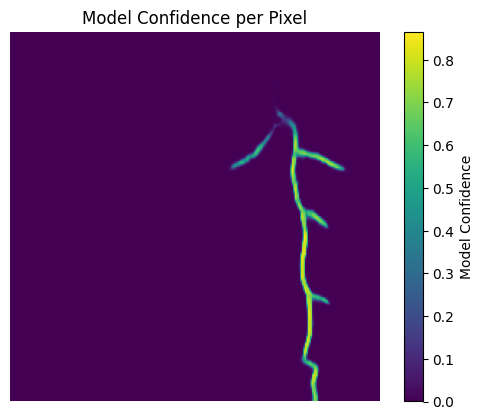

In [27]:
import matplotlib.pyplot as plt

confidence_map = pred[0, :, :, 0]  # Remove batch and channel dims

plt.imshow(confidence_map, cmap='viridis')  # or 'plasma', 'hot', etc.
plt.colorbar(label="Model Confidence")
plt.title("Model Confidence per Pixel")
plt.axis('off')
plt.show()

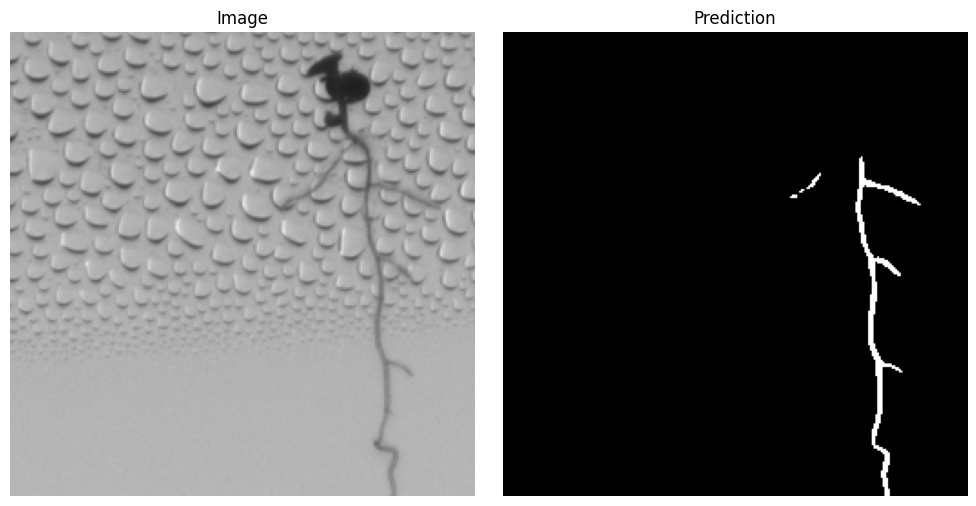

In [28]:
pred = (pred > 0.5).astype(np.uint8)

pred_img = np.squeeze(pred, axis=0)
pred_vis = (pred_img * 255).astype(np.uint8)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # width x height in inches

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

# Prediction
plt.subplot(1, 2, 2)
plt.imshow(pred_vis, cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
model.save("unet_model.h5")